## Intent Classification

In [1]:
!nvidia-smi

Sun Aug 16 05:36:46 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install tensorflow-gpu >> /dev/null

In [3]:
!pip install --upgrade grpcio >> /dev/null

In [4]:
!pip install tqdm >> /dev/null

In [5]:
!pip install bert-for-tf2 >> /dev/null

In [6]:
!pip install sentencepiece >> /dev/null

In [7]:
import os
import math
import datetime

from tqdm import tqdm

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc

%matplotlib inline
%config InlineBackent.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ['#1BBEFE', '#FFDD00', '#FF7D00', '#FF7D006D', '#ADFF02',  '#8F00FF']

#sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))


rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [8]:
!gdown --id 1OlcvGWReJMuyYQuOZm149vHWwPtlboR6 --output train.csv
!gdown --id 1Oi5cRlTybuIF2Fl5Bfsr-KkqrXrdt77w --output valid.csv
!gdown --id 1ep9H6-HvhB4utJRLVcLzieWNUSG3P_uF --output test.csv

Downloading...
From: https://drive.google.com/uc?id=1OlcvGWReJMuyYQuOZm149vHWwPtlboR6
To: /content/train.csv
100% 799k/799k [00:00<00:00, 116MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Oi5cRlTybuIF2Fl5Bfsr-KkqrXrdt77w
To: /content/valid.csv
100% 43.3k/43.3k [00:00<00:00, 38.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ep9H6-HvhB4utJRLVcLzieWNUSG3P_uF
To: /content/test.csv
100% 43.1k/43.1k [00:00<00:00, 70.8MB/s]


In [9]:
train = pd.read_csv('train.csv')
valid = pd.read_csv('valid.csv')
test = pd.read_csv('test.csv')

In [10]:
train = train.append(valid).reset_index(drop=True)

In [11]:
train.shape

(13784, 2)

In [12]:
train.head()

,text,intent
0,listen to westbam alumb allergic on google music,PlayMusic
1,add step to me to the 50 clásicos playlist,AddToPlaylist
2,i give this current textbook a rating value of...,RateBook
3,play the song little robin redbreast,PlayMusic
4,please add iris dement to my playlist this is ...,AddToPlaylist


In [13]:
train.intent.value_counts()

PlayMusic               2014
GetWeather              1996
BookRestaurant          1981
RateBook                1976
SearchScreeningEvent    1952
SearchCreativeWork      1947
AddToPlaylist           1918
Name: intent, dtype: int64

In [14]:
train.intent.unique()

array(['PlayMusic', 'AddToPlaylist', 'RateBook', 'SearchScreeningEvent',
       'BookRestaurant', 'GetWeather', 'SearchCreativeWork'], dtype=object)

In [15]:
labels = ['PlayMusic', 'GetWeather', 'BookRestaurant',
          'RateBook',   'SearchScreeningEvent',
         'SearchCreativeWork', 'AddToPlaylist']

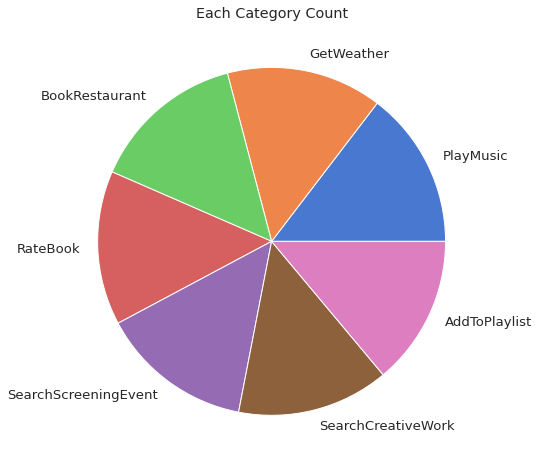

In [16]:
plt.pie(train.intent.value_counts(), labels=labels)
plt.title('Each Category Count')
plt.show()

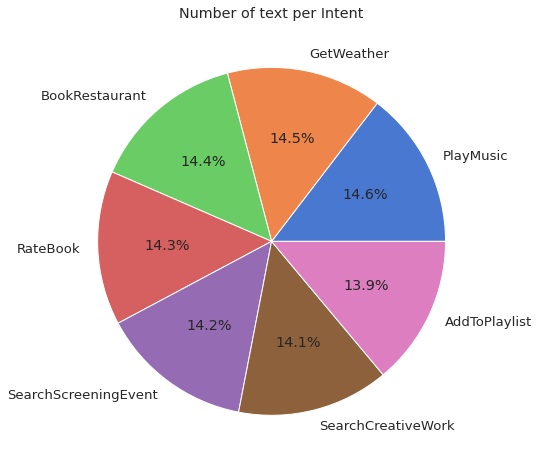

In [17]:
plt.pie(train.intent.value_counts(), autopct='%1.1f%%', labels=labels)
plt.title('Number of text per Intent')
plt.show()

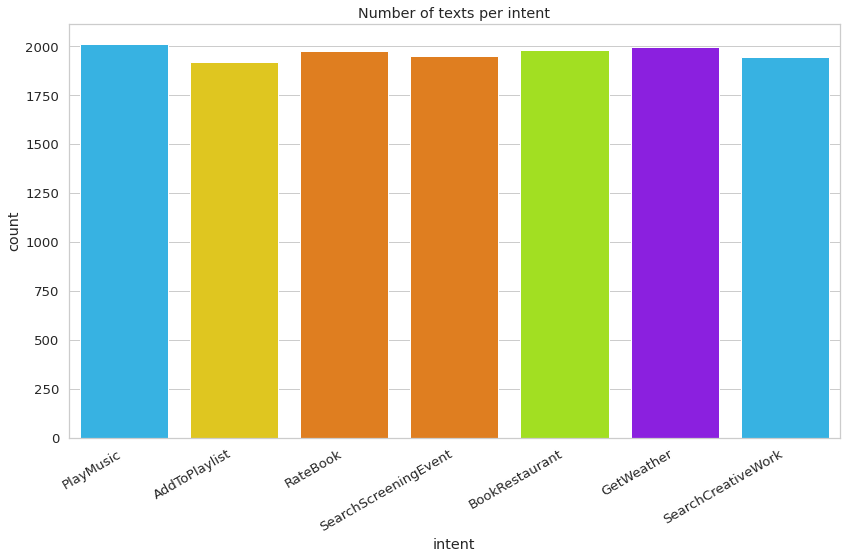

In [18]:
chart = sns.countplot(train.intent, palette=HAPPY_COLORS_PALETTE)
plt.title('Number of texts per intent')
chart.set_xticklabels(chart.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.tight_layout()
plt.show()

In [19]:
# Download Pre-Training BERT Model

!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip

--2020-08-16 05:45:51--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.135.128, 74.125.28.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip’

uncased_L-12_H-768_ 100%[===================>] 388.84M   207MB/s    in 1.9s    

2020-08-16 05:45:53 (207 MB/s) - ‘uncased_L-12_H-768_A-12.zip’ saved [407727028/407727028]



In [21]:
!unzip uncased_L-12_H-768_A-12.zip

Archive:  uncased_L-12_H-768_A-12.zip
replace uncased_L-12_H-768_A-12/bert_model.ckpt.meta? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [24]:
os.makedirs('model', exist_ok=True)

In [25]:
!mv uncased_L-12_H-768_A-12/ model

In [27]:
bert_model_name = 'uncased_L-12_H-768_A-12'

bert_ckpt_dir = os.path.join('model/', bert_model_name)

bert_ckpt_file = os.path.join(bert_ckpt_dir, 'bert_model.ckpt')

bert_config_file = os.path.join(bert_ckpt_dir, 'bert_config.json')

In [28]:
bert_ckpt_file

'model/uncased_L-12_H-768_A-12/bert_model.ckpt'

Preprocessing

In [29]:
train.head()

,text,intent
0,listen to westbam alumb allergic on google music,PlayMusic
1,add step to me to the 50 clásicos playlist,AddToPlaylist
2,i give this current textbook a rating value of...,RateBook
3,play the song little robin redbreast,PlayMusic
4,please add iris dement to my playlist this is ...,AddToPlaylist


In [80]:
class IntentDetectionData:
    DATA_COLUMN = 'text'
    LABEL_COLUMN = 'intent'

    def __init__(self, train, test, tokenizer: FullTokenizer, classes, max_seq_len=192):
      self.tokenizer = tokenizer
      self.max_seq_len = 0
      self.classes = classes

      ((self.train_x, self.train_y), (self.test_x, self.test_y)) =\
        map(self._prepare, [train, test])

      self.max_seq_len = min(self.max_seq_len, max_seq_len)
      self.train_x, self.test_x = map(self._pad, [self.train_x, self.test_x])

    def _prepare(self, df):
      x, y = [], []

      for _, row in tqdm(df.iterrows()):
        text, label =\
          row[IntentDetectionData.DATA_COLUMN], row[IntentDetectionData.LABEL_COLUMN]
        
        tokens = self.tokenizer.tokenize(text)
        tokens = ['[CLS]'] + tokens + ['[SEP]']
        token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
        
        self.max_seq_len = max(self.max_seq_len, len(token_ids))

        x.append(token_ids)
        y.append(self.classes.index(label))

      return np.array(x), np.array(y)
    
    def _pad(self, ids):
      x = []
      for input_ids in ids:
        cut_point = min(len(input_ids), self.max_seq_len -2)
        input_ids = input_ids[:cut_point] 
        input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids))
        x.append(np.array(input_ids))

      return np.array(x)

    

In [75]:
tokenizer = FullTokenizer(vocab_file=os.path.join(bert_ckpt_dir, 'vocab.txt'))

In [76]:
tokenizer.tokenize("I can't wait to visit Mumbai!")

['i', 'can', "'", 't', 'wait', 'to', 'visit', 'mumbai', '!']

In [77]:
tokens = tokenizer.tokenize("I can't wait to visit Mumbai!")
tokenizer.convert_tokens_to_ids(tokens)

[1045, 2064, 1005, 1056, 3524, 2000, 3942, 8955, 999]

In [92]:
# https://www.youtube.com/watch?v=gE-95nFF4Cc&t=72s
def create_model(max_seq_len, bert_config_file, bert_ckpt_file):

  with tf.io.gfile.GFile(bert_config_file, "r") as reader:
      bc = StockBertConfig.from_json_string(reader.read())
      bert_params = map_stock_config_to_params(bc)
      bert_params.adapter_size = None
      bert = BertModelLayer.from_params(bert_params, name="bert")
  input_ids = keras.layers.Input(
    shape=(max_seq_len, ),
    dtype='int32',
    name="input_ids"
  )
  bert_output = bert(input_ids)
  print ('Bert Shape', bert_output.shape)

  cls_out = keras.layers.Lambda(lambda seq: seq[:, 0, :])(bert_output)
  cls_out = keras.layers.Dropout(0.5)(cls_out)
  logits = keras.layers.Dense(units=768, activation='tanh')(cls_out)
  logits = keras.layers.Dropout(0.5)(logits)
  logits = keras.layers.Dense(units=len(classes), activation='softmax')(logits)


  model = keras.Model(inputs=input_ids, outputs=logits)

  model.build(input_shape=(None, max_seq_len))

  load_stock_weights(bert, bert_ckpt_file)

  return model



In [81]:
classes = train.intent.unique().tolist()
#print (classes)

data = IntentDetectionData(train, test, tokenizer, classes, max_seq_len=128)

13784it [00:03, 3655.75it/s]
700it [00:00, 3633.28it/s]


In [93]:
model = create_model(data.max_seq_len, bert_config_file, bert_ckpt_file)

Bert Shape (None, 38, 768)
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7fd8f3db3e80> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights


In [94]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 38)]              0         
_________________________________________________________________
bert (BertModelLayer)        (None, 38, 768)           108890112 
_________________________________________________________________
lambda_2 (Lambda)            (None, 768)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 768)               590592    
_________________________________________________________________
dropout_5 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 7)                

In [95]:
data.train_x.shape

(13784, 38)

In [98]:
print (data.train_y[1])
print (data.train_y[3])


1
0


In [103]:
print (tokenizer.tokenize(train.text[0]))
print (len(tokenizer.tokenize(train.text[0])))
print (train.text[0])
data.train_x[0]

['listen', 'to', 'west', '##ba', '##m', 'al', '##umb', 'allergic', 'on', 'google', 'music']
11
listen to westbam alumb allergic on google music


array([  101,  4952,  2000,  2225,  3676,  2213,  2632, 25438, 27395,
        2006,  8224,  2189,   102,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0])

In [100]:
train.text[0]

'listen to westbam alumb allergic on google music'

In [110]:
model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name='acc')]

)

In [112]:
log_dir = 'log/intent_detection'+datetime.datetime.now().strftime('%Y%m%d-%H%M%s')


In [113]:
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir)

history = model.fit(
    x=data.train_x,
    y=data.train_y,
    validation_split=0.1,
    batch_size=16,
    shuffle=True,
    epochs=5,
    callbacks=[tensorboard_callback]
)

Epoch 1/5
  1/776 [..............................] - ETA: 0s - loss: 1.9230 - acc: 0.1875WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
776/776 [==============================] - 261s 337ms/step - loss: 1.3025 - acc: 0.8763 - val_loss: 1.1858 - val_acc: 0.9804
Epoch 2/5
776/776 [==============================] - 261s 336ms/step - loss: 1.1867 - acc: 0.9803 - val_loss: 1.1765 - val_acc: 0.9891
Epoch 3/5
776/776 [==============================] - 261s 336ms/step - loss: 1.1794 - acc: 0.9866 - val_loss: 1.1854 - val_acc: 0.9782
Epoch 4/5
776/776 [==============================] - 261s 336ms/step - loss: 1.1764 - acc: 0.9897 - val_loss: 1.1753 - val_acc: 0.9906
Epoch 5/5
776/776 [==============================] - 261s 336ms/step - loss: 1.1761 - acc: 0.9897 - val

In [115]:
_, text_acc = model.evaluate(data.test_x, data.test_y)


22/22 [==============================] - 2s 96ms/step - loss: 1.1856 - acc: 0.9800


In [116]:
y_pred = model.predict(data.test_x).argmax(axis=1)

In [119]:
from sklearn.metrics import classification_report
print (classification_report(data.test_y, y_pred, target_names=classes))

                      precision    recall  f1-score   support

           PlayMusic       0.95      1.00      0.97        86
       AddToPlaylist       0.99      1.00      1.00       124
            RateBook       1.00      1.00      1.00        80
SearchScreeningEvent       1.00      0.94      0.97       107
      BookRestaurant       0.98      1.00      0.99        92
          GetWeather       1.00      0.98      0.99       104
  SearchCreativeWork       0.94      0.94      0.94       107

            accuracy                           0.98       700
           macro avg       0.98      0.98      0.98       700
        weighted avg       0.98      0.98      0.98       700



In [192]:
sentences = [
            'play our song now',
            'Rate this book as awful',
             'Reserve a table for two'
]

tokens = map(tokenizer.tokenize, sentences)
tokens = map(lambda tok: ["[CLS]"]+ tok + ["[SEP]"], tokens)


In [193]:
token_ids = list(map(tokenizer.convert_tokens_to_ids, tokens))

token_ids = map(
    lambda tids: tids + [0]*(data.max_seq_len - len(tids)), 
    token_ids
  )
pred_token_ids = np.array(list(token_ids))
predictions = model.predict(pred_token_ids).argmax(axis=-1)

In [194]:
for text, label in zip(sentences, predictions):
  print("text:", text, "\nintent:", classes[label])
  print()

text: play our song now 
intent: PlayMusic

text: Rate this book as awful 
intent: RateBook

text: Reserve a table for two 
intent: BookRestaurant

